In [ ]:
!nvidia-smi
%matplotlib inline

Sun Jun 15 15:52:06 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 565.57.01              Driver Version: 565.57.01      CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:CA:00.0 Off |                    0 |
| N/A   30C    P0             49W /  400W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
!pip install --upgrade datasets fsspec

In [ ]:
!pip install dspy

In [1]:
import dspy
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from tqdm import tqdm
from typing import List, Literal, List, Dict, Any
from dspy.evaluate import Evaluate
from dspy import LabeledFewShot
from dspy.teleprompt import BootstrapFewShotWithRandomSearch
import numpy as np
import seaborn as sns

from datasets import load_dataset
import random
import json
import re
from functools import partial
from datasets import Dataset
from copy import deepcopy
import evaluate
import nltk
from scipy.stats import ttest_ind
import string
from collections import Counter

/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
# For Snellius
learning_csv = "./data/in-context_learning_set.csv"

In [ ]:
"""
module load CUDA/12.4.0
source ~/sglang-venv-2/bin/activate
huggingface-cli login


# 创建所有必要的目录
mkdir -p /scratch-local/yhuang/sglang_cache
mkdir -p /scratch-local/yhuang/huggingface_cache
mkdir -p /scratch-local/yhuang/torch_cache
mkdir -p /scratch-local/yhuang/cuda_cache
mkdir -p /scratch-local/yhuang/xdg_cache
mkdir -p /scratch-local/yhuang/tmp
mkdir -p /scratch-local/yhuang/logs

# 设置所有相关环境变量
export SGLANG_CACHE_DIR=/scratch-local/yhuang/sglang_cache
export TRANSFORMERS_CACHE=/scratch-local/yhuang/huggingface_cache
export HF_HOME=/scratch-local/yhuang/huggingface_cache
export HF_DATASETS_CACHE=/scratch-local/yhuang/huggingface_cache/datasets
export TORCH_HOME=/scratch-local/yhuang/torch_cache
export CUDA_CACHE_PATH=/scratch-local/yhuang/cuda_cache
export XDG_CACHE_HOME=/scratch-local/yhuang/xdg_cache
export TMPDIR=/scratch-local/yhuang/tmp
export TEMP=/scratch-local/yhuang/tmp
export TMP=/scratch-local/yhuang/tmp
export SGLANG_LOG_DIR=/scratch-local/yhuang/logs

# launching
python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-4B --trust-remote-code
CUDA_VISIBLE_DEVICES=0,1 python -m sglang.launch_server --port 7501 --model-path Qwen/Qwen3-32B --trust-remote-code --tp 2
"""

## Pre-processing Google NQ data (dev set for now)

In [ ]:
import os

os.environ["HF_DATASETS_CACHE"] = "/scratch-local/yhuang/huggingface_cache"
# 确保目录存在
os.makedirs('/scratch-local/yhuang/huggingface_cache', exist_ok=True)

In [ ]:
dataset = load_dataset("google-research-datasets/natural_questions", "dev")["validation"]

Resolving data files:   0%|          | 0/287 [00:00<?, ?it/s]

In [ ]:
def simplify_nq_example(example):
    question = example['question']['text']

    # "Annotation" is of dict structure, and each entry is a list
    annotations = example['annotations']

    simplified_example = {
        'question': question,
        'short_answers': [],
        'long_answer': ''
    }

    # if long_answer entry exists
    long_answer_idx = next((idx for idx, la in enumerate(annotations['long_answer']) if la['start_token'] != -1), None)
    if long_answer_idx is not None:
        la = annotations['long_answer'][long_answer_idx]
        start_token, end_token = la['start_token'], la['end_token']
        simplified_example['long_answer'] = ' '.join(
            example['document']['tokens']['token'][start_token:end_token]
        )

        # the short answer
        short_answer = annotations['short_answers'][long_answer_idx]
        simplified_example['short_answers'] = short_answer['text']

    return simplified_example

def remove_html_tags(text):
    clean = re.compile(r"<.*?>")
    return re.sub(clean, "", text)

def simplify_nq_example_clean(example):
    simplified = simplify_nq_example(example)
    simplified["long_answer"] = remove_html_tags(simplified["long_answer"])
    return simplified

simplified_dataset = dataset.map(simplify_nq_example_clean, remove_columns=dataset.column_names)

In [ ]:
"""
# Filtering out data points where both "long answer" and "short answer" are empty
def has_any_answer(example):
    long_ok = example["long_answer"].strip() != ""
    short_ok = len(example["short_answers"]) > 0
    return long_ok or short_ok

filtered_dataset = simplified_dataset.filter(has_any_answer)
"""

# Only keeping examples with both short and long answers
filtered_dataset = simplified_dataset.filter(
    lambda x: x["long_answer"].strip() != "" and len(x["short_answers"]) > 0
)
print(len(simplified_dataset))
print(len(filtered_dataset))
#print(len(filtered_dataset))

7830
3516


In [ ]:
sampled_dataset = filtered_dataset.shuffle(seed=42).select(range(1000))

In [ ]:
sampled_dataset[1]['question']

'when was the first book made into a movie'

## Inputting questions into the DSPy Classifier

#### Loading a model

In [ ]:
model = dspy.LM("openai/Qwen/Qwen3-4B",
                 api_base="http://localhost:7501/v1",
                 api_key="whatever", model_type='chat', cache=False)

dspy.configure(lm=model)

#### Helper functions

In [ ]:
def run_batch(batch, class_to_use):
    results = []
    for request in batch["question"]:
        try:
            result = class_to_use(request=request)
            results.append({
                "category": result.category,
                "judgment": result.judgment,
                "reasoning": getattr(result, "reasoning", "")
            })
        except Exception as e:
            results.append({
                "category": "error",
                "judgment": "error",
                "reasoning": "error"
            })
    return {
        "category": [r["category"] for r in results],
        "judgment": [r["judgment"] for r in results],
        "reasoning": [r["reasoning"] for r in results]
    }



def collect_thinking(loaded_model):
  history_data = loaded_model.history
  think_list = []
  print(f'The current length of history is {len(history_data)}.')

  for record in history_data:
      thinking = record['outputs'][0].split("[[ ## reasoning ## ]]")[0]
      think_list.append(thinking)

  return think_list

def collect_thinking_streaming(loaded_model, output_path):
    history_data = loaded_model.history
    print(f'The current length of history is {len(history_data)}.')

    with open(output_path, 'w', encoding='utf-8') as f:
        for record in history_data:
            thinking = record['outputs'][0].split("[[ ## reasoning ## ]]")[0]
            json.dump({"thinking": thinking}, f)
            f.write('\n')


# In-context learning data loading and preprocessing
def load_data(csv_path):
    """Load CSV data and convert to DSPy examples"""
    df = pd.read_csv(csv_path)

    examples = []
    for _, row in df.iterrows():
        if pd.notna(row['request']) and pd.notna(row['gold_judgment']):
            example = dspy.Example(
                request=row['request'],
                reasoning=row['reasoning'] if pd.notna(row['reasoning']) else '',
                category=row['category'] if pd.notna(row['category']) else '',
                judgment=row['gold_judgment']
            ).with_inputs('request')  # Only request is input
            examples.append(example)

    return examples

def add_columns_to_dataset(dataset, columns_dict, inplace=False):
    """
    Adding multiple columns to a HuggingFace Dataset

    params：
        dataset (Dataset): The original dataset
        columns_dict (dict): The new columns organized in a dict, keys are column names, value lists should be of the same length with Dataset
        inplace (bool): whether to change the orignial Dataset or create a new copy

    return：
        Dataset: The new dataset with new columns added
    """
    if not inplace:
        dataset = deepcopy(dataset)

    for column_name, values in columns_dict.items():
        if len(values) != len(dataset):
            raise ValueError(f"长度不匹配：'{column_name}' 列长度为 {len(values)}，但数据集有 {len(dataset)} 条样本。")
        dataset = dataset.add_column(column_name, values)

    return dataset

#### The one-hop program from the last experiment

In [ ]:
class Classification(dspy.Signature):
  request: str = dspy.InputField(desc="An input user question/request.")
  category: Literal['Undetermined perspective or granularity', 'Missing necessary components', 'Undetermined lexicons or references', 'Undetermined standard or preference', 'fully specified']=dspy.OutputField(desc="Select one or more labels (comma-separated): Undetermined perspective or granularity, Missing necessary components, Undetermined lexicons or references, Undetermined standard or preference. If fully clear, output 'fully specified'")
  judgment: Literal['underspecified', 'fully specified'] = dspy.OutputField(desc="Final judgment: 'underspecified' if any undetermined factors exist, 'fully specified' if completely clear.")

# Load your in-context learning set
examples = load_data(learning_csv)
print(f"Loaded {len(examples)} samples from in-context learning set")

optimizer = dspy.LabeledFewShot(k=150)

# Compiling
program = dspy.ChainOfThought(Classification)
compiled_program = optimizer.compile(program, trainset=examples)

# One-shot Testing
result = compiled_program(request="Who is the president?")
print(result)

# Encapsule the compiled_program into the batch running function
wrapped_batch = partial(run_batch, class_to_use=compiled_program)

Loaded 150 samples from in-context learning set
Prediction(
    reasoning='The request is underspecified because the term “president” can refer to multiple parallel political entities (e.g., U.S. president, French president, Chinese president), and the question lacks a necessary component to specify which country or jurisdiction is being referred to. Without this context, the referent remains ambiguous.',
    category='Undetermined lexicons or references',
    judgment='underspecified'
)


In [ ]:
# batch parameters
batch_size = 10
num_samples = len(sampled_dataset)
batches = [sampled_dataset.select(range(i, min(i + batch_size, num_samples))) for i in range(0, num_samples, batch_size)]

# Initialize a dict of outputs with empty lists using designated keys
all_outputs = {"category": [], "judgment": [], "reasoning": []}

# tqdm progress bar
for batch in tqdm(batches, desc="Running DSPy classification"):
    out = wrapped_batch(batch)
    for key in all_outputs:
        all_outputs[key].extend(out[key])

Running DSPy classification:  97%|█████████▋| 97/100 [1:50:05<03:14, 64.77s/it]

In [ ]:
# 合并回原数据集
annotated_dataset = add_columns_to_dataset(sampled_dataset, all_outputs)

# 筛选 judgment 为 "underspecified" 的子集（忽略大小写与前后空格）
underspecified_set = annotated_dataset.filter(
    lambda x: x["judgment"].strip().lower() == "underspecified"
)

# 筛选 judgment 为 "fully specified" 的子集
fully_specified_set = annotated_dataset.filter(
    lambda x: x["judgment"].strip().lower() == "fully specified"
)

# 可选：输出每个子集的大小
print(f"Underspecified samples: {len(underspecified_set)}")
print(f"Fully specified samples: {len(fully_specified_set)}")

annotated_dataset.to_json("classified_results_all.jsonl", orient="records", lines=True)
underspecified_set.to_json("classified_results_UND.jsonl", orient="records", lines=True)
fully_specified_set.to_json("classified_results_FS.jsonl", orient="records", lines=True)

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Filter:   0%|          | 0/100 [00:00<?, ? examples/s]

Underspecified samples: 36
Fully specified samples: 64


Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

75790

In [ ]:
annotated_dataset[0]

{'question': 'where does the modern view of history originate from',
 'short_answers': ['approximately in the early 16th century'],
 'long_answer': "  The early modern period began approximately in the early 16th century ; notable historical milestones included the European Renaissance , the Age of Discovery , and the Protestant Reformation .   The late modern period began approximately in the mid-18th century ; notable historical milestones included the French Revolution , the American Revolution , the Industrial Revolution and the Great Divergence . It took all of human history up to 1804 for the world 's population to reach 1 billion ; the next billion came just over a century later , in 1927 .   Contemporary history is the span of historic events from approximately 1945 that are immediately relevant to the present time .  ",
 'category': 'Undetermined standard or preference',
 'judgment': 'underspecified',
 'reasoning': 'The request is underspecified because the phrase “modern view

In [ ]:
# Collect thinking
think_list = collect_thinking(model)
print(f"The number of thinking pieces is {len(think_list)}.")
think_df = pd.DataFrame(think_list)
think_df.to_csv('think_GoogleNQ_second_test.csv')

collect_thinking_streaming(model, "think_GoogleNQ_second_test.jsonl")

The current length of history is 117.
The number of thinking pieces is 117.
The current length of history is 117.


In [ ]:
df = pd.read_json("classified_results_all.jsonl", lines=True)
df.to_csv('Google_NQ_second_test.csv')
df

,question,short_answers,long_answer,category,judgment,reasoning
0,where does the modern view of history originat...,[approximately in the early 16th century],The early modern period began approximately ...,Undetermined standard or preference,underspecified,The request is underspecified because the phra...
1,when was the first book made into a movie,[1924],"In 1924 , Erich von Stroheim attempted a lite...",Undetermined standard or preference,underspecified,The request is underspecified because the term...
2,when did the study of media effects begin,[1919],The social impact of mass communication has b...,fully specified,fully specified,This question is fully specified because it as...
3,where are the giant redwoods located in califo...,"[Humboldt County, Del Norte County]",Redwood National and State Parks IUCN c...,fully specified,fully specified,This question is fully specified because it cl...
4,when did the first wireless beats come out,[October 2012],"In October 2012 , Beats unveiled its first tw...",Undetermined lexicons or references,underspecified,The request is underspecified because the term...
...,...,...,...,...,...,...
995,who is the drummer for guns and roses,[Frank Ferrer],Image Name Years active Instruments ...,fully specified,fully specified,This question is fully specified because it re...
996,where was the movie 500 days of summer filmed,[Los Angeles],David Ng of the Los Angeles Times describes a...,fully specified,fully specified,This question is fully specified because it cl...
997,what was the lowest barometric pressure for hu...,[914 mbar (hPa; 27.0 inHg)],In between Rita and Katrina is Hurricane Alle...,fully specified,fully specified,This question is fully specified because it re...
998,what is the meaning of auv in cars,[action utility vehicles],"In Australia and New Zealand , the term SUV i...",Undetermined lexicons or references,underspecified,The request is underspecified because the term...


## QA implementations

#### Loading back the classified subsets

In [ ]:
underspecified_set = load_dataset(
    "json",
    data_files="classified_results_UND.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

fully_specified_set = load_dataset(
    "json",
    data_files="classified_results_FS.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

#### Loading an LLM for short and long QA programs

In [ ]:
lm = dspy.LM('openai/gpt-4o-2024-11-20', api_key='')
dspy.configure(lm=lm)

In [ ]:
class ShortListQASignature(dspy.Signature):
    """Answer the question with concise responses. Return answers as a list of strings. If there's only one answer, return a single-item list. Each answer should be brief and direct."""

    question: str = dspy.InputField(desc="The question to be answered")
    answer: List[str] = dspy.OutputField(desc="List of concise answers, even if only one answer exists")

class FlexibleQASignature(dspy.Signature):
    """Answer the question thoroughly and helpfully. Provide context, explanations, and relevant details from Wikipedia that would help the user understand the topic better."""

    question: str = dspy.InputField(desc="The question to be answered")
    answer: str =  dspy.OutputField(desc="A comprehensive answer with explanations and context")

In [ ]:
short_qa = dspy.ChainOfThought(ShortListQASignature)
long_qa = dspy.ChainOfThought(FlexibleQASignature)

"""
result1 = short_qa(question="What are the primary colors?")
result2 = long_qa(question="What are the primary colors?")
print(result1.answer)
print(result2.answer)


result3 = short_qa(question="What is the capital of France?")
result4 = long_qa(question="What is the capital of France?")
print(result3.answer)
print(result4.answer)
"""

'\nresult1 = short_qa(question="What are the primary colors?")\nresult2 = long_qa(question="What are the primary colors?")\nprint(result1.answer)\nprint(result2.answer)\n\n\nresult3 = short_qa(question="What is the capital of France?")\nresult4 = long_qa(question="What is the capital of France?")\nprint(result3.answer)\nprint(result4.answer)\n'

### Helper functions to run QA in batches

In [ ]:
def run_batch_shortQA(batch, class_to_use):
    short_answers = []
    for q in batch["question"]:
        try:
            result = class_to_use(question=q)
            short_answers.append(result.answer)  # expect List[str]
        except Exception as e:
            print(f"Error: {e}")
            short_answers.append(["error"])
    return {"model_short_answer": short_answers}

def run_batch_longQA(batch, class_to_use):
    long_answers = []
    for q in batch["question"]:
        try:
            result = class_to_use(question=q)
            long_answers.append(result.answer)  # expect str
        except Exception as e:
            print(f"Error: {e}")
            long_answers.append("error")
    return {"model_long_answer": long_answers}

def batch_QA_with_progress(
    dataset,
    batch_fn,
    output_key: str,
    batch_size: int = 10,
    fill_value = "error"  # 可设为 "", [], None 视字段结构而定
):
    """
    批量运行 QA 推理函数，支持 tqdm 进度条和自动字段对齐。

    参数：
        dataset     : HuggingFace Dataset 对象
        batch_fn    : 函数，接受一个 batch（Dataset），返回 {output_key: [...]} 格式
        output_key  : 字符串，结果输出的列名
        batch_size  : 每个 batch 的样本数（默认 8）
        fill_value  : 若 batch_fn 返回空，则使用的默认填充值

    返回：
        dict[str, list]，可以用于 add_column()
    """
    all_outputs = []

    for i in tqdm(range(0, len(dataset), batch_size), desc=f"Running {output_key}"):
        batch = dataset.select(range(i, min(i + batch_size, len(dataset))))
        try:
            output = batch_fn(batch)
            if output_key not in output:
                raise ValueError(f"Output key '{output_key}' not found in batch_fn result.")
            all_outputs.extend(output[output_key])
        except Exception as e:
            print(f"Batch error at index {i}: {e}")
            all_outputs.extend([fill_value] * len(batch))

    # 最终长度对不上，也填补
    if len(all_outputs) != len(dataset):
        print(f"[Warning] Length mismatch: expected {len(dataset)}, got {len(all_outputs)}. Auto-padding.")
        all_outputs.extend([fill_value] * (len(dataset) - len(all_outputs)))

    return {output_key: all_outputs}

#### Implementation

In [ ]:
short_results_UND = batch_QA_with_progress(
    underspecified_set,
    batch_fn=partial(run_batch_shortQA, class_to_use=short_qa),
    output_key="model_short_answer",
    fill_value=["error"]
)

Running model_short_answer: 100%|██████████| 31/31 [05:33<00:00, 10.75s/it]


In [ ]:
long_results_UND = batch_QA_with_progress(
    underspecified_set,
    batch_fn=partial(run_batch_longQA, class_to_use=long_qa),
    output_key="model_long_answer",
    fill_value="error"
)

Running model_long_answer: 100%|██████████| 31/31 [15:18<00:00, 29.62s/it]


In [ ]:
# batch QA for FS
short_results_FS = batch_QA_with_progress(
    fully_specified_set,
    batch_fn=partial(run_batch_shortQA, class_to_use=short_qa),
    output_key="model_short_answer",
    fill_value=["error"]
)

Running model_short_answer: 100%|██████████| 70/70 [12:03<00:00, 10.34s/it]


In [ ]:
long_results_FS = batch_QA_with_progress(
    fully_specified_set,
    batch_fn=partial(run_batch_longQA, class_to_use=long_qa),
    output_key="model_long_answer",
    fill_value="error"
)

Running model_long_answer: 100%|██████████| 70/70 [32:39<00:00, 27.99s/it]


In [ ]:
qa_underspecified = deepcopy(underspecified_set)

for key in short_results_UND:
    qa_underspecified = qa_underspecified.add_column(key, short_results_UND[key])
for key in long_results_UND:
    qa_underspecified = qa_underspecified.add_column(key, long_results_UND[key])

qa_underspecified.to_json("classified_results_UND_qa.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1066537

In [ ]:
qa_fully_specified = deepcopy(fully_specified_set)

for key in short_results_FS:
    qa_fully_specified = qa_fully_specified.add_column(key, short_results_FS[key])
for key in long_results_FS:
    qa_fully_specified = qa_fully_specified.add_column(key, long_results_FS[key])

qa_fully_specified.to_json("classified_results_FS_qa.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

2019237

In [ ]:
df = pd.read_json("classified_results_UND_qa.jsonl", lines=True)
df.to_csv('Google_NQ_UND_QA_second_test.csv')

df = pd.read_json("classified_results_FS_qa.jsonl", lines=True)
df.to_csv('Google_NQ_FS_QA_second_test.csv')

## Evaluations

In [ ]:
underspecified_set_qa = load_dataset(
    "json",
    data_files="classified_results_UND_qa.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

fully_specified_set_qa = load_dataset(
    "json",
    data_files="classified_results_FS_qa.jsonl",
    split="train"
)

Generating train split: 0 examples [00:00, ? examples/s]

Generating train split: 0 examples [00:00, ? examples/s]

#### Squad EM + F1

In [ ]:
# Official squad script for avg EM and F1, not possible for t-test


# Evaluate fully specified subset
dataset = load_dataset("json", data_files="classified_results_FS_qa.jsonl", split="train")

# 加载 HuggingFace 的 squad 评估器
squad_metric = evaluate.load("squad")

# 构造 predictions 和 references（标准格式）
predictions = [
    {
        "id": str(i),
        "prediction_text": pred[0] if isinstance(pred, list) and pred else ""
    }
    for i, pred in enumerate(dataset["model_short_answer"])
]

references = [
    {
        "id": str(i),
        "answers": {
            "text": ref if isinstance(ref, list) else [ref],
            "answer_start": [0] * len(ref if isinstance(ref, list) else [ref])
        }
    }
    for i, ref in enumerate(dataset["short_answers"])
]

# 计算 SQuAD-style EM 和 F1
results = squad_metric.compute(predictions=predictions, references=references)

# 打印平均指标
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 36.12
F1 Score: 52.76


In [ ]:
# Evaluate underspecified subset
dataset = load_dataset("json", data_files="classified_results_UND_qa.jsonl", split="train")

# 加载 HuggingFace 的 squad 评估器
squad_metric = evaluate.load("squad")

# 构造 predictions 和 references（标准格式）
predictions = [
    {
        "id": str(i),
        "prediction_text": pred[0] if isinstance(pred, list) and pred else ""
    }
    for i, pred in enumerate(dataset["model_short_answer"])
]

references = [
    {
        "id": str(i),
        "answers": {
            "text": ref if isinstance(ref, list) else [ref],
            "answer_start": [0] * len(ref if isinstance(ref, list) else [ref])
        }
    }
    for i, ref in enumerate(dataset["short_answers"])
]

# 计算 SQuAD-style EM 和 F1
results = squad_metric.compute(predictions=predictions, references=references)

# 打印平均指标
print(f"Exact Match: {results['exact_match']:.2f}")
print(f"F1 Score: {results['f1']:.2f}")

Exact Match: 23.93
F1 Score: 36.29


In [ ]:
def evaluate_squad_per_sample_multi_ref_pred(dataset, pred_col="model_short_answer", ref_col="short_answers"):
    """
    对每个样本逐一计算 EM 和 F1，支持多个参考答案和多个预测答案（list[str]）。
    返回带 "em", "f1" 列的新 Dataset，以及 f1/em 列表用于统计分析。
    Also considering multiple answers in both gold and pred and take the maximum score
    """

    def normalize_answer(s):
        def remove_articles(text):
            return re.sub(r'\b(a|an|the)\b', ' ', text)
        def white_space_fix(text):
            return ' '.join(text.split())
        def remove_punc(text):
            return ''.join(ch for ch in text if ch not in string.punctuation)
        def lower(text):
            return text.lower()
        return white_space_fix(remove_articles(remove_punc(lower(s))))

    def compute_exact(a_pred, a_gold):
    # 如果是 list，转成 set 并 normalize 每个元素
        if isinstance(a_pred, list) and isinstance(a_gold, list):
          pred_set = set(normalize_answer(a) for a in a_pred)
          gold_set = set(normalize_answer(a) for a in a_gold)
          return int(pred_set == gold_set)
        else:
          return int(normalize_answer(a_pred) == normalize_answer(a_gold))

    def compute_f1(a_pred, a_gold):
        pred_tokens = normalize_answer(a_pred).split()
        gold_tokens = normalize_answer(a_gold).split()
        common = Counter(pred_tokens) & Counter(gold_tokens)
        num_same = sum(common.values())
        if num_same == 0:
            return 0.0
        precision = num_same / len(pred_tokens)
        recall = num_same / len(gold_tokens)
        return 2 * precision * recall / (precision + recall)

    new_data = []
    f1_scores = []
    em_scores = []

    for item in dataset:
        preds = item.get(pred_col, [])
        golds = item.get(ref_col, [])
        # 转为 list
        if not isinstance(preds, list):
            preds = [preds] if preds else []
        if not isinstance(golds, list):
            golds = [golds] if golds else []

        # 多对多最大匹配
        if not preds or not golds:
            em = 0.0
            f1 = 0.0
        else:
            em = max(compute_exact(p, g) for p in preds for g in golds)
            f1 = max(compute_f1(p, g) for p in preds for g in golds)

        new_item = deepcopy(item)
        new_item["em"] = em
        new_item["f1"] = f1
        new_data.append(new_item)
        em_scores.append(em)
        f1_scores.append(f1)

    return Dataset.from_list(new_data), f1_scores, em_scores

In [ ]:
squad_scored_UND, UND_f1_list, UND_em_list = evaluate_squad_per_sample_multi_ref_pred(underspecified_set_qa)
squad_scored_UND.to_json("classified_results_UND_qa_with_squad_scores.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

1072562

In [ ]:
squad_scored_FS, FS_f1_list, FS_em_list = evaluate_squad_per_sample_multi_ref_pred(fully_specified_set_qa)
squad_scored_FS.to_json("classified_results_FS_qa_with_squad_scores.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

2033248

In [ ]:
df = pd.read_json("classified_results_UND_qa_with_squad_scores.jsonl", lines=True)
df.to_csv('Google_NQ_UND_QA_SQUAD_second_test.csv')

df = pd.read_json("classified_results_FS_qa_with_squad_scores.jsonl", lines=True)
df.to_csv('Google_NQ_FS_QA_SQUAD_second_test.csv')

In [ ]:
UND_mean_em = np.mean(UND_em_list)  # em_scores: EM list per sample
UND_mean_f1 = np.mean(UND_f1_list)  # f1_scores F1 list per sample
print(f"UND Exact Match (avg): {UND_mean_em * 100:.2f}")
print(f"UND F1 Score (avg): {UND_mean_f1 * 100:.2f}")

FS_mean_em = np.mean(FS_em_list)  # em_scores: EM list per sample
FS_mean_f1 = np.mean(FS_f1_list)  # f1_scores F1 list per sample
print(f"FS Exact Match (avg): {FS_mean_em * 100:.2f}")
print(f"FS F1 Score (avg): {FS_mean_f1 * 100:.2f}")

f1_tstat, f1_pval = ttest_ind(FS_f1_list, UND_f1_list, equal_var=False)
print(f"F1: t={f1_tstat:.3f}, p={f1_pval:.4f}")

em_tstat, em_pval = ttest_ind(FS_em_list, UND_em_list, equal_var=False)
print(f"EM: t={em_tstat:.3f}, p={em_pval:.4f}")

UND Exact Match (avg): 25.57
UND F1 Score (avg): 39.78
FS Exact Match (avg): 37.41
FS F1 Score (avg): 55.03
F1: t=5.322, p=0.0000
EM: t=3.813, p=0.0002


#### Visualization

In [ ]:
df_f1 = pd.DataFrame({
    "F1": FS_f1_list + UND_f1_list,
    "Subset": ["Fully specified"] * len(FS_f1_list) + ["Underspecified"] * len(UND_f1_list)
})

plt.figure(figsize=(6, 4))
sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)
plt.title("F1 Score Distribution by Subset")
plt.tight_layout()
plt.savefig("f1_swarm_boxplot_second_test.png")
plt.close()

df_em = pd.DataFrame({
    "EM": FS_em_list + UND_em_list,
    "Subset": ["Fully specified"] * len(FS_em_list) + ["Underspecified"] * len(UND_em_list)
})

plt.figure(figsize=(6, 4))
sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)
plt.title("Exact Match Rate by Subset (± CI)")
plt.tight_layout()
plt.savefig("em_barplot_second_test.png")
plt.close()

/scratch-local/yhuang.12391364/ipykernel_3038232/2533103266.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Subset", y="F1", data=df_f1, palette="Set2", showfliers=False)
/scratch-local/yhuang.12391364/ipykernel_3038232/2533103266.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)
/scratch-local/yhuang.12391364/ipykernel_3038232/2533103266.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Subset", y="EM", data=df_em, palette="Set2", ci=95)


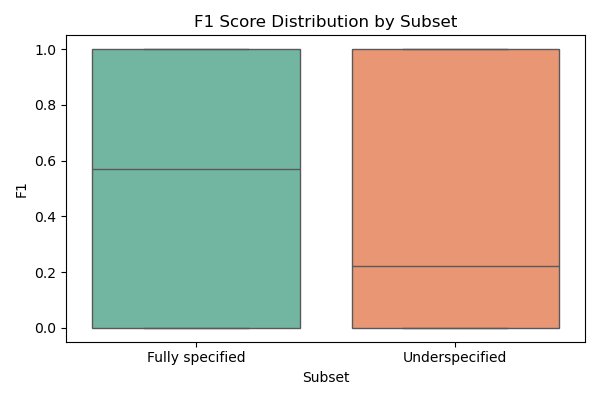

In [ ]:
from IPython.display import Image
Image("f1_swarm_boxplot_second_test.png")

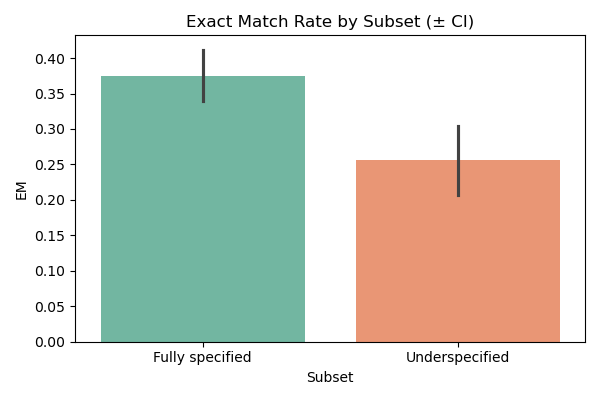

In [ ]:
Image("em_barplot_second_test.png")

#### BLEU, ROUGE, METEOR, BERTScore

In [ ]:
UND = load_dataset(
    "json",
    data_files="classified_results_UND_qa_with_squad_scores.jsonl",
    split="train"  # 必须指定 split，否则默认返回 DatasetDict
)

FS = load_dataset(
    "json",
    data_files="classified_results_FS_qa_with_squad_scores.jsonl",
    split="train"
)

In [ ]:
def evaluate_long_answer_all_metrics(
    dataset: Dataset,
    pred_col: str,
    ref_col: str,
    metrics: list = ["bleu", "meteor", "rouge", "bertscore"]
) -> dict:
    """
    对 dataset 中每条样本逐一计算多个文本生成评估指标。
    支持 BLEU, METEOR, ROUGE-L, BERTScore。

    Args:
        dataset: HuggingFace Dataset。
        pred_col: 模型预测列名（str）。
        ref_col: 参考答案列名（str）。
        metrics: 要计算的指标列表，支持 "bleu", "meteor", "rouge", "bertscore"。

    Returns:
        Dict[str, List[float]]: 每个指标对应一个分数列表。
    """
    metric_objects = {m: evaluate.load(m) for m in metrics}
    all_scores = {m: [] for m in metrics}

    for item in tqdm(dataset, desc="Evaluating metrics"):
        pred = item[pred_col]
        ref = item[ref_col]

        if not pred or not ref:
            for m in metrics:
                all_scores[m].append(0.0)
            continue

        for m in metrics:
            try:
                if m == "rouge":
                    result = metric_objects[m].compute(predictions=[pred], references=[[ref]])
                    all_scores[m].append(result["rougeL"])
                elif m == "bertscore":
                    result = metric_objects[m].compute(predictions=[pred], references=[ref], lang="en")
                    all_scores[m].append(result["f1"][0])  # 取 BERTScore F1 分数
                else:
                    result = metric_objects[m].compute(predictions=[pred], references=[[ref]])
                    all_scores[m].append(result[m])
            except Exception as e:
                print(f"Error scoring sample with {m}: {e}")
                all_scores[m].append(0.0)

    return all_scores

def add_scores_to_dataset(dataset, scores_dict):
    """
    将多个指标打分列表合并为 dataset 的新列。

    Args:
        dataset (Dataset): 原始 HuggingFace Dataset。
        scores_dict (dict): 如 {"bleu": [...], "meteor": [...]}，每个值都是 len=N 的分数列表。

    Returns:
        Dataset: 增加了评估分数的新数据集。
    """

    # 确保每个指标的分数长度与数据集行数一致
    for k, v in scores_dict.items():
        assert len(v) == len(dataset), f"Length mismatch for {k}: {len(v)} != {len(dataset)}"

    # 加入每个指标为新列
    new_dataset = dataset
    for k, v in scores_dict.items():
        new_dataset = new_dataset.add_column(k, v)

    return new_dataset
def t_test_metrics(scores_1: dict, scores_2: dict, label_1="Group 1", label_2="Group 2"):
    """
    对两个子集的多个指标进行 t-test，并打印结果。

    Args:
        scores_1 (dict): 子集 1 的评估分数，形式为 {"metric": [scores]}。
        scores_2 (dict): 子集 2 的评估分数，形式相同。
    """
    common_metrics = set(scores_1.keys()) & set(scores_2.keys())

    print(f"\nT-test results between {label_1} and {label_2}:\n")
    for metric in sorted(common_metrics):
        x = scores_1[metric]
        y = scores_2[metric]

        t_stat, p_val = ttest_ind(x, y, equal_var=False)
        print(f"{metric.upper():<10} | t = {t_stat:6.3f} | p = {p_val:.4f} | "
              f"{'significant' if p_val < 0.05 else 'not significant'}")

def plot_metric_distributions(scores_1, scores_2, label_1="Group 1", label_2="Group 2", filename="metric_plot.png"):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from IPython.display import Image

    # 构建 DataFrame
    rows = []
    for metric in scores_1:
        if metric in scores_2:
            for v in scores_1[metric]:
                rows.append({"score": v, "metric": metric.upper(), "group": label_1})
            for v in scores_2[metric]:
                rows.append({"score": v, "metric": metric.upper(), "group": label_2})
    df = pd.DataFrame(rows)

    # 绘图设置
    sns.set(style="whitegrid", font_scale=1.1)
    g = sns.catplot(
        data=df, kind="box", x="metric", y="score", hue="group",
        height=5, aspect=1.6, palette="Set2", showfliers=True  # Keep outliers，remove swarm
    )

    g.set_axis_labels("Metric", "Score")
    g.set_titles("Metric Score Distributions")
    g.despine(left=True)
    plt.title("Long Answer Evaluation Score Distributions by Group")
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

    return Image(filename)

In [ ]:
scores_UND = evaluate_long_answer_all_metrics(
    dataset=UND,
    pred_col="model_long_answer",
    ref_col="long_answer"
)

scores_FS = evaluate_long_answer_all_metrics(
    dataset=FS,
    pred_col="model_long_answer",
    ref_col="long_answer"
)

[nltk_data] Downloading package wordnet to /home/yhuang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/yhuang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/yhuang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
Evaluating metrics:   0%|          | 0/305 [00:00<?, ?it/s]Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Evaluating metrics: 100%|██████████| 305/305 [18:23<00:00,  3.62s/it]
[nltk_data] Downloading package wordnet to /home/yhuang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/yhuang/nltk_data...
[nltk_data]   Package punkt_tab 

In [ ]:
# 合并
UND_with_most_metrics = add_scores_to_dataset(UND, scores_UND)
FS_with_most_metrics = add_scores_to_dataset(FS, scores_FS)

# 保存为新 jsonl（可选）
UND_with_most_metrics.to_json("test_UND_with_most_metrics.jsonl")
FS_with_most_metrics.to_json("test_FS_with_most_metrics.jsonl")

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

2091252

In [ ]:
t_test_metrics(scores_FS, scores_UND, label_1="UND", label_2="FS")


T-test results between UND and FS:

BERTSCORE  | t =  3.295 | p = 0.0010 | significant
BLEU       | t =  4.569 | p = 0.0000 | significant
METEOR     | t =  2.874 | p = 0.0042 | significant
ROUGE      | t =  4.154 | p = 0.0000 | significant


/home/yhuang/sglang-venv-2/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/scratch-local/yhuang.12392093/ipykernel_1523604/1604551131.py:117: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


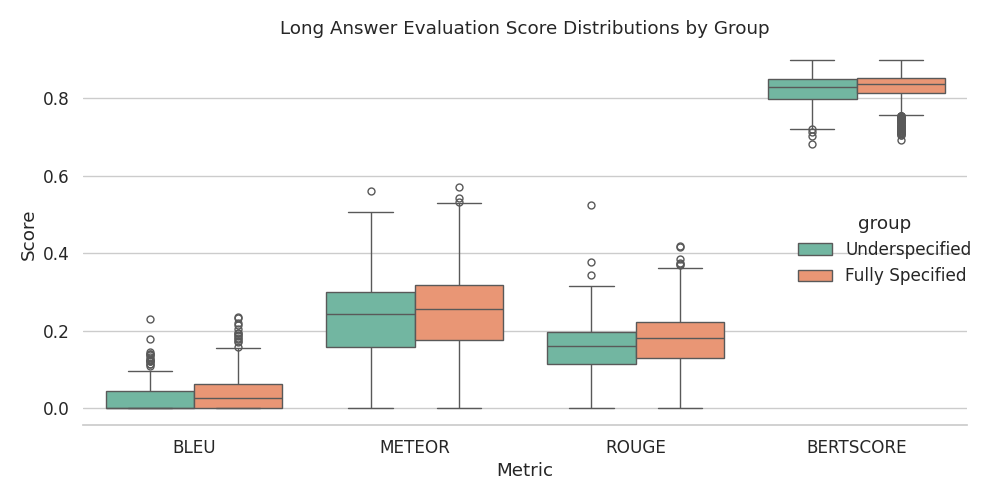

In [ ]:
plot_metric_distributions(scores_UND, scores_FS, label_1="Underspecified", label_2="Fully Specified")

In [2]:
df = pd.read_json("test_UND_with_most_metrics.jsonl", lines=True)
df.to_csv('test_UND_with_most_metrics.csv')
df = pd.read_json("test_FS_with_most_metrics.jsonl", lines=True)
df.to_csv('test_FS_with_most_metrics.csv')